In [3]:
# try:
#   # Componentes a instalar si abrimos la notebook desde Google Colab
#   import google.colab
#   %pip install roboticstoolbox-python>=1.0.2
# except:
#   # No estamos en Google Colab
#   from IPython.core.display import HTML
#   import pathlib
#   styles_path = pathlib.Path(pathlib.Path().absolute(), "style", "style.css")
#   styles = open(styles_path, "r").read()
#   HTML(f"<style>{styles}</style>")

In [1]:
# Hacemos todas las importaciones necesarias
# numpy para manejar array y algebra lineal
import numpy as np
import scipy as sc
# la funcionalidad específica de robótica está en el toolbox
import roboticstoolbox as rtb
# spatialmath tiene define los grupos de transformaciones especiales: rotación SO3 y eculideo SE3
import spatialmath as sm
import spatialmath.base.symbolic as sym
import matplotlib.pyplot as plt  

In [2]:
# Preparo el modelo de un doble péndulo
dp = rtb.DHRobot(
    [
        rtb.RevoluteDH(a=200e-3,m=1.5,
                r=np.array([-100, 0, 0]) * 1e-3,
                I=np.array([0,0,0,0,0,0,0,0,1e-3]),
                B=1, G=1),                
        rtb.RevoluteDH(a=200e-3,m=1,
                r=np.array([-100, 0, 0]) * 1e-3,
                I=np.array([0,0,0,0,0,0,0,0,1e-3]),
                B=1, G=1),                                
    ], 
    gravity = np.array([0, -9.8, 0]), # Ojo con el signo, la gravedad va hacia abajo con signo positivo
    name = "dp_TP5")

qr = np.array([-np.pi/2,0])
qz = np.zeros((2,))

print(dp)
print(dp.dynamics())

DHRobot: dp_TP5, 2 joints (RR), dynamics, standard DH parameters
┌────┬────┬─────┬──────┐
│θⱼ  │ dⱼ │ aⱼ  │  ⍺ⱼ  │
├────┼────┼─────┼──────┤
│ q1 │  0 │ 0.2 │ 0.0° │
│ q2 │  0 │ 0.2 │ 0.0° │
└────┴────┴─────┴──────┘

┌─┬──┐
└─┴──┘

┌──────┬──────┬──────────────┬────────────────────────────┬────┬────┬────────┬────┐
│  j   │  m   │      r       │             I              │ Jm │ B  │   Tc   │ G  │
├──────┼──────┼──────────────┼────────────────────────────┼────┼────┼────────┼────┤
│link1 │  1.5 │ -0.1,  0,  0 │  0,  0,  0.001,  0,  0,  0 │  0 │  1 │  0,  0 │  1 │
│link2 │  1   │ -0.1,  0,  0 │  0,  0,  0.001,  0,  0,  0 │  0 │  1 │  0,  0 │  1 │
└──────┴──────┴──────────────┴────────────────────────────┴────┴────┴────────┴────┘

None


In [3]:
# Dinámica inversa 
# de la docu:
# rne(q, qd=None, qdd=None, gravity=None, fext=None, base_wrench=False)[source]
#    Inverse dynamics
#    Parameters
#            q (ndarray(n)) – Joint coordinates
#            qd (ndarray(n)) – Joint velocity
#            qdd (ndarray(n)) – The joint accelerations of the robot
#            gravity (ndarray(6)) – Gravitational acceleration to override robot’s gravity value
#            fext (ndarray(6)) – Specify wrench acting on the end-effector 

q = qz
qd = np.zeros((2,))
qdd = np.zeros((2,))
tau = dp.rne(q, qd, qdd)
print(tau)

print(dp.inertia(q))
print(dp.coriolis(q, qd))
print(dp.gravload(q))


[4.41 0.98]
[[0.107 0.031]
 [0.031 0.011]]
[[0. 0.]
 [0. 0.]]
[4.41 0.98]


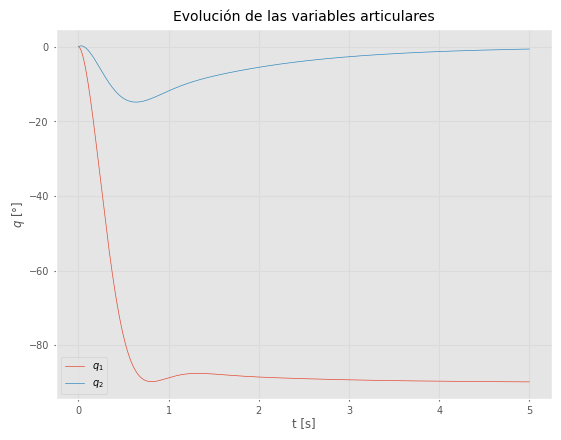

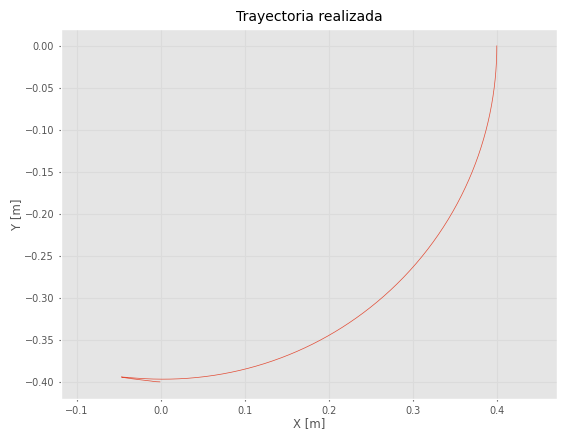

In [4]:
# Simulación del sistema dinámico
# De la docu:
# fdyn(T, q0, torque=None, torque_args={}, qd0=None, solver='RK45', solver_args={}, dt=None, progress=False) 
# Integrate forward dynamics
#    Parameters
#            T (float) – integration time
#            q0 (array_like) – initial joint coordinates
#            qd0 (array_like) – initial joint velocities, assumed zero if not given
#            torque – a function that computes torque as a function of time


tg = dp.nofriction(coulomb=True, viscous=False).fdyn(5, qz,qd0=np.zeros((2,)),dt=1e-3)
plt.plot(tg.t,tg.q*180/np.pi)
plt.xlabel('t [s]')
plt.ylabel(r'$q$ [°]')
plt.legend([r'$q_1$',r'$q_2$'])
plt.title('Evolución de las variables articulares')
plt.show()

trayectoria = dp.fkine(tg.q)
X = trayectoria.t[:,0]
Y = trayectoria.t[:,1]
Z = trayectoria.t[:,2]

plt.plot(X,Y)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Trayectoria realizada')
plt.axis('equal')
plt.show()


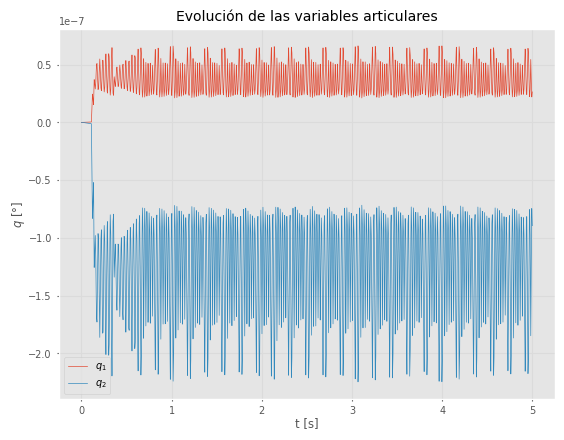

In [8]:
# Repito la simulación pero aplicando un torque que compense el peso propio
def torque_sosten(robot, t, q, qd):
  return np.array([4.41,0.98])

tg = dp.nofriction().fdyn(5, qz,torque=torque_sosten,qd0=np.zeros((2,)),dt=1e-3)

plt.plot(tg.t,tg.q*180/np.pi)
plt.xlabel('t [s]')
plt.ylabel(r'$q$ [°]')
plt.legend([r'$q_1$',r'$q_2$'])
plt.title('Evolución de las variables articulares')
plt.show()


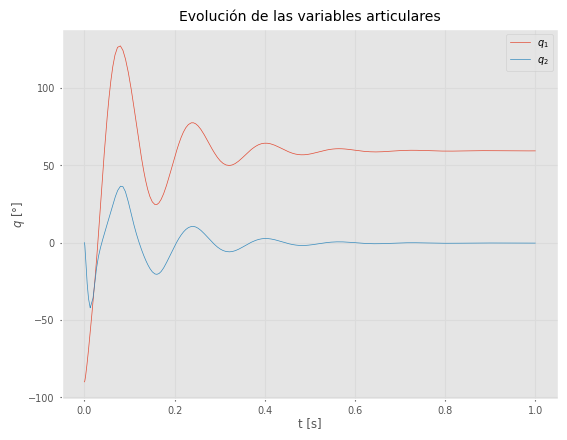

In [9]:
# Evaluo la respuesta al escalón

def controlPD(robot, t, q, qd, q_deseado, Kp, Kd):
    return Kp.dot(q_deseado - q) - Kd.dot(qd)

Kp = np.diag([200, 100]) 
Kd = np.diag([2, 1]) 

q_deseado = np.array([np.pi/3,0])

tg = dp.nofriction(True,True).fdyn(1, qr, torque=controlPD, torque_args={'q_deseado':q_deseado, 'Kp':Kp, 'Kd':Kd},dt=1e-4) 

plt.plot(tg.t,tg.q*180/np.pi)
plt.xlabel('t [s]')
plt.ylabel(r'$q$ [°]')
plt.legend([r'$q_1$',r'$q_2$'])
plt.title('Evolución de las variables articulares')
plt.show()



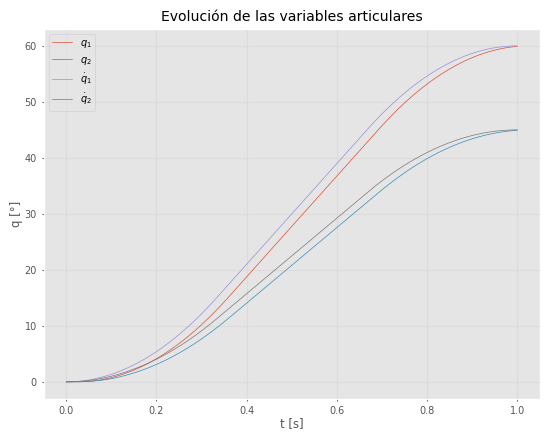

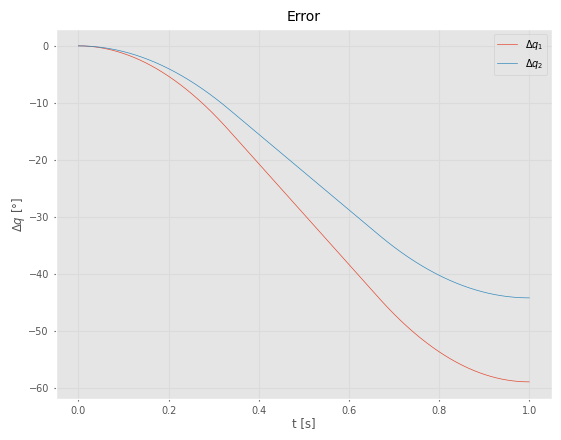

In [10]:
# Evaluo la respuesta a una trayectoria
dt = 1e-4
n_samples = 10000
Tspan = n_samples * dt
q_des1 = rtb.trapezoidal(0, np.pi/3, n_samples)
q_des2 = rtb.trapezoidal(0, np.pi/4, n_samples)
#q_des = rtb.mtraj(rtb.trapezoidal, qr, np.array([np.pi/3,0]), n_samples)
q_des = np.array([q_des1.q,q_des2.q])

def controlPD(robot, t, q, qd, q_deseado, Kp, Kd):
    idx = np.round(t/dt).astype(int)
    if idx>=n_samples:
      idx=-1
    q_ref = q_deseado[:,idx]
    # problema: el integrador toma mas muestras? ---> paso variable ??
    return Kp.dot(q_ref - q) - Kd.dot(qd) + robot.gravload(q)

Kp = np.diag([400, 200]) 
Kd = np.diag([10, 5]) 

q_deseado = np.array([np.pi/3,0])

tg = dp.nofriction(True,True).fdyn(1, qz, torque=controlPD, torque_args={'q_deseado':q_des, 'Kp':Kp, 'Kd':Kd},dt=1e-4) 
plt.plot(tg.t,tg.q*180/np.pi)
plt.plot(tg.t,q_des.transpose()*180/np.pi)
plt.xlabel('t [s]')
plt.ylabel('q [°]')
plt.legend([r'$q_1$',r'$q_2$',r'$\dot{q}_1$',r'$\dot{q}_2$'])
plt.title('Evolución de las variables articulares')
plt.show()


plt.plot(tg.t,tg.q-q_des.transpose()*180/np.pi)
plt.xlabel('t [s]')
plt.ylabel(r'$\Delta q$ [°]')
plt.legend([r'$\Delta q_1$',r'$\Delta q_2$'])
plt.title('Error')
plt.show()


In [11]:
# Esto sería para hallar el modelo simbólico de la dinámica
from spatialmath.base import symbol

# link 1
m1 = symbol('m_1')
l1 = symbol('l_1')
lc1 = symbol('l_c_1')

# link 2
m2 = symbol('m_2')
l2 = symbol('l_2')
lc2 = symbol('l_c_2')

g = symbol('g')

L1 = rtb.RevoluteDH(a=l1, m=m1, r=[-lc1, 0, 0])
L2 = rtb.RevoluteDH(a=l2, m=m2, r=[-lc2, 0, 0])
robot =rtb.DHRobot([L1, L2], gravity=[0, g, 0], symbolic=True)


q = symbol('q_:2')
qd = symbol('qd_:2')
robot.rne_python(q, qd, [0, 0])

array([-1.0*g*m_1*(l_1 - l_c_1)*cos(q_0) + 1.0*l_1*m_2*(-1.0*g*cos(q_0)*cos(q_1) - 1.0*(-g*sin(q_0) - 1.0*l_1*qd_0**2)*sin(q_1))*cos(q_1) + 1.0*l_1*m_2*(-1.0*g*sin(q_1)*cos(q_0) - l_2*(1.0*qd_0 + 1.0*qd_1)**2 + l_c_2*(1.0*qd_0 + 1.0*qd_1)**2 + (-g*sin(q_0) - 1.0*l_1*qd_0**2)*cos(q_1))*sin(q_1) + 1.0*m_2*(l_2 - l_c_2)*(-1.0*g*cos(q_0)*cos(q_1) - 1.0*(-g*sin(q_0) - 1.0*l_1*qd_0**2)*sin(q_1)),
       1.0*m_2*(l_2 - l_c_2)*(-1.0*g*cos(q_0)*cos(q_1) - 1.0*(-g*sin(q_0) - 1.0*l_1*qd_0**2)*sin(q_1))],
      dtype=object)